<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [39]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch import nn

from zipfile import ZipFile
import requests
import io

In [40]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [41]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [42]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [43]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [44]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

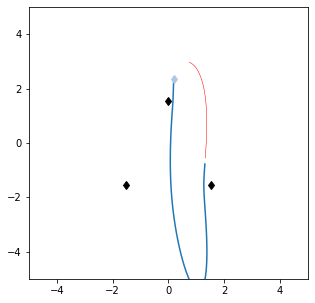

Charges are [-0.48758687 -0.84045168 -0.15073235]


In [45]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [46]:
# The inputs for this model would be the location of each particle (p1, p2, p3, p4), the initial charges for p2, p3, and p4
# The output is a set of charges at every t, for the maximum

# 1. Sort the input sequences by length <- Saving this for optimization later
# 2. Pad the input sequences to the maximum length per batch, thus minimizing the amount of padding in the input
  # This is 110
# 3. Put the input sequences into a dataloader, for shuffling and batching

# Maybe sorting isn't even necessary, because the sequences are not that long to begin with.
# Padding with 0s is usually done, but this could reduce accuracy for longer sequences, as most examples will have 0 at the end.
# I think we can combat this by not calculating loss for the sequence past its usefulness.


In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [48]:
simulation_train_tensor_no_padding = torch.zeros(800, 90, 1, 2)
simulation_train_tensor_with_padding = torch.zeros(800, 110, 1, 2)
simulation_train_no_nothing = []
for i in range(800):
  tensor = torch.Tensor(simulation_train[i])
  simulation_train_no_nothing.append(tensor)
  simulation_train_tensor_with_padding[i] = F.pad(tensor, (0,0,0,110 - tensor.shape[0])).unsqueeze(dim=1)
  simulation_train_tensor_no_padding[i] = tensor[-90:, :].unsqueeze(dim=1)

simulation_eval = torch.zeros(100, 90, 1, 2)
simulation_eval_no_nothing = []
for i in range(100):
  tensor = torch.Tensor(simulation_valid[i])
  simulation_eval_no_nothing.append(tensor)
  simulation_eval[i] = tensor[-90:, :].unsqueeze(dim=1)

simulation_test_no_nothing = []
for i in range(100):
    tensor = torch.Tensor(simulation_test[i])
    simulation_test_no_nothing.append(tensor)

In [50]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, input_tensor, output_tensor):
        self.input_tensor = input_tensor
        self.output_tensor = output_tensor

    def __len__(self):
        return len(self.input_tensor)

    def __getitem__(self, idx):
        return self.input_tensor[idx], self.output_tensor[idx].unsqueeze(dim=0)

train_dataset = CustomDataset(simulation_train_tensor_no_padding, torch.Tensor(charges_train))
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

train_dataset_padding = CustomDataset(simulation_train_tensor_with_padding, torch.Tensor(charges_train))
train_dataloader_padding = DataLoader(train_dataset_padding, batch_size=1, shuffle=True)

eval_dataset = CustomDataset(simulation_eval_no_nothing, torch.Tensor(charges_valid))
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

test_dataset = CustomDataset(simulation_test_no_nothing, torch.Tensor(charges_test))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train_no_nothing = CustomDataset(simulation_train_no_nothing, torch.Tensor(charges_train))
train_no_nothing_dataloader = DataLoader(train_no_nothing, batch_size=1, shuffle=True)

## Model Implementation

In [51]:
class LSTM1(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTM1, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        
        # Define a fully connected layer
        self.fc =  nn.Linear(hidden_dim, hidden_dim)
        #self.out = nn.Linear(128, hidden_dim)
        
        # Define dropout layer
        #self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, inputs):
        # Forward through lstm layer
        _, (h_n, c_n) = self.lstm(inputs)
        
        # Forward through dense layer
        hidden = self.fc(h_n)
        #hidden = self.dropout(hidden) # Apply drop-out 
        #hidden = self.out(hidden)
        
        return hidden

## Model Training

In [52]:
# Define runtime device
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyper parameter and model definition
input_dim = 2
hidden_dim = 3
lstm = LSTM1(input_dim, hidden_dim).to(dev)

criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)
num_epochs = 100
dataloader = train_no_nothing_dataloader

lossPerEpoch = np.empty((num_epochs, 1))
lossEvalPerEpoch = np.empty((num_epochs, 1))
lossTestPerEpoch = np.empty((num_epochs, 1))
errorPerEpoch = np.empty((num_epochs, 3))

for epoch in range(num_epochs):
  total_loss = 0
  total_eval_loss = 0
  total_test_loss = 0
  total_error = 0
  total_validation_error = 0

  # Set in train mode
  lstm.train()

  # Train the model
  iterator = iter(dataloader)
  for i in range(len(iterator)):
    x, y = next(iterator)
    
    # Move to GPU
    x = x.to(dev)
    y = y.to(dev)

    # Propagate forward
    hidden = lstm(x[0])
    
    # Compute loss
    loss = criterion(hidden, y[0])
    total_loss += loss.item()
    
    # Store error per for each prediction [c2 c3 c4]
    expected = y[0][0].cpu().numpy()
    predicted = hidden[0].cpu().detach().numpy()
    total_error += expected - predicted
    
    # Backward propagate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  # Set in eval mode
  lstm.eval()

  # Evaluate loss on verification set
  eval_iterator = iter(eval_dataloader)
  for i in range(len(eval_iterator)):
    with torch.no_grad():
      x, y = next(eval_iterator)
    
      # Move to GPU
      x = x.to(dev)
      y = y.to(dev)
    
      # Propagate forward
      hidden = lstm(x[0])
    
      # Compute loss
      loss = criterion(hidden, y[0])
      total_eval_loss += loss.item()
        
      # Store error per for each prediction [c2 c3 c4]
      expected = y[0][0].cpu().numpy()
      predicted = hidden[0].cpu().detach().numpy()
      total_validation_error += expected - predicted
        
  # Evaluate loss on test set
  test_iterator = iter(test_dataloader)
  for i in range(len(test_iterator)):
    with torch.no_grad():
      x, y = next(test_iterator)
    
      # Move to GPU
      x = x.to(dev)
      y = y.to(dev)
    
      # Propagate forward
      hidden = lstm(x[0])
    
      # Compute loss
      loss = criterion(hidden, y[0])
      total_test_loss += loss.item()
        
      # Store error per for each prediction [c2 c3 c4]
      #expected = y[0][0].cpu().numpy()
      #predicted = hidden[0].cpu().detach().numpy()
      #total_test_error += expected - predicted
    
        
  average_training_loss = total_loss / len(iterator)
  average_eval_loss = total_eval_loss / len(eval_iterator)
  average_test_loss = total_test_loss / len(test_iterator)
  average_training_error = total_error / len(iterator)
  average_validation_error = total_validation_error / len(eval_iterator)
    
  lossPerEpoch[epoch] = average_training_loss
  lossEvalPerEpoch[epoch] = average_eval_loss
  lossTestPerEpoch[epoch] = average_test_loss
  errorPerEpoch[epoch] = average_training_error

  print(f'epoch: {epoch+1}, mean training loss: {average_training_loss}, mean eval loss: {average_eval_loss}, \nepoch: {epoch+1}, training error: {average_training_error}, \nepoch: {epoch+1}, validation error: {average_validation_error}')

  

#TODO: Might need to zero out the hidden state of lstm, but maybe not
#TODO: Experiment with num_layers


epoch: 1, mean training loss: 0.3807266805670224, mean eval loss: 0.27300089626573026, 
epoch: 1, training error: [-0.55745953 -0.37543905 -0.5984379 ], 
epoch: 1, validation error: [-0.509201   -0.2646414  -0.39478347]
epoch: 2, mean training loss: 0.18756431355752284, mean eval loss: 0.16541947349905967, 
epoch: 2, training error: [-0.32265407 -0.20692772 -0.3253155 ], 
epoch: 2, validation error: [-0.32953265 -0.1430285  -0.19984934]
epoch: 3, mean training loss: 0.12565511359018275, mean eval loss: 0.12836050648242237, 
epoch: 3, training error: [-0.18429326 -0.12198849 -0.18164366], 
epoch: 3, validation error: [-0.22766903 -0.07543202 -0.09682575]
epoch: 4, mean training loss: 0.10414819069992517, mean eval loss: 0.11373626636341214, 
epoch: 4, training error: [-0.10984867 -0.06977203 -0.10405465], 
epoch: 4, validation error: [-0.16894335 -0.04026895 -0.04246012]
epoch: 5, mean training loss: 0.09533961731154704, mean eval loss: 0.1069355620071292, 
epoch: 5, training error: [-0

epoch: 38, mean training loss: 0.07845263006107416, mean eval loss: 0.08924747588112951, 
epoch: 38, training error: [-0.00301908  0.00043711 -0.00078653], 
epoch: 38, validation error: [-0.08128196  0.00857923  0.03030329]
epoch: 39, mean training loss: 0.07837569065406569, mean eval loss: 0.08905614224262536, 
epoch: 39, training error: [-0.0030266   0.00255368  0.00209219], 
epoch: 39, validation error: [-0.07998019  0.00728311  0.02870242]
epoch: 40, mean training loss: 0.07830916917213472, mean eval loss: 0.08911000456195324, 
epoch: 40, training error: [ 0.00188778 -0.00045    -0.00028023], 
epoch: 40, validation error: [-0.08196814  0.00807602  0.02871835]
epoch: 41, mean training loss: 0.07824032972654095, mean eval loss: 0.08891068233177066, 
epoch: 41, training error: [-0.00386647  0.00250535 -0.00098883], 
epoch: 41, validation error: [-0.08005252  0.00676995  0.02912591]
epoch: 42, mean training loss: 0.07817560389514255, mean eval loss: 0.08883294112049044, 
epoch: 42, tra

epoch: 75, mean training loss: 0.07657606535249215, mean eval loss: 0.08697804590687155, 
epoch: 75, training error: [ 2.8292759e-05  1.9519100e-03 -5.3052395e-04], 
epoch: 75, validation error: [-0.07905068  0.0061111   0.02867614]
epoch: 76, mean training loss: 0.0765364401730767, mean eval loss: 0.08695722576230765, 
epoch: 76, training error: [-2.4962754e-04  6.0489028e-06  5.5809738e-04], 
epoch: 76, validation error: [-0.07953533  0.00665932  0.02861756]
epoch: 77, mean training loss: 0.07650419326459086, mean eval loss: 0.08689932028762996, 
epoch: 77, training error: [-0.00082442  0.00109     0.00226201], 
epoch: 77, validation error: [-0.07956935  0.00647972  0.02734413]
epoch: 78, mean training loss: 0.07647100810845586, mean eval loss: 0.08681477127596736, 
epoch: 78, training error: [-0.00145972  0.00300577  0.00207632], 
epoch: 78, validation error: [-0.07910036  0.0049995   0.02619187]
epoch: 79, mean training loss: 0.0764292109843518, mean eval loss: 0.08683849011547863,

In [53]:
# without padding :epoch: 25, mean training loss: 0.08195400983095169, mean eval loss: 0.09817712453918324
# epoch: 100, mean training loss: 0.0861954316496849, mean eval loss: 0.10278522804379463

In [54]:
# without any cutting : epoch: 56, mean training loss: 0.07555700838565826, mean eval loss: 0.08626986091025174
# With linear layer: epoch: 56, mean training loss: 0.07898687571287155, mean eval loss: 0.08656595157459378
# With reLU + linear layer: epoch: 56, mean training loss: 0.08114010095596313, mean eval loss: 0.09263360679149628

100
torch.Size([1, 3])
torch.Size([1, 3])


## Evaluation

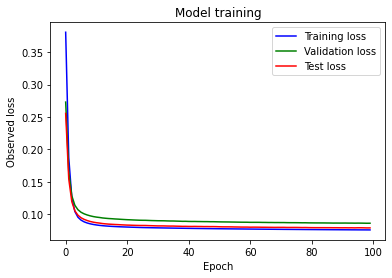

In [55]:
# Plot the loss curve
plt.figure()
plt.plot(range(num_epochs), lossPerEpoch, "b-", label="Training loss")
plt.plot(range(num_epochs), lossEvalPerEpoch, "g-", label="Validation loss")
plt.plot(range(num_epochs), lossTestPerEpoch, "r-", label="Test loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Observed loss")
plt.title("Model training")
plt.show()

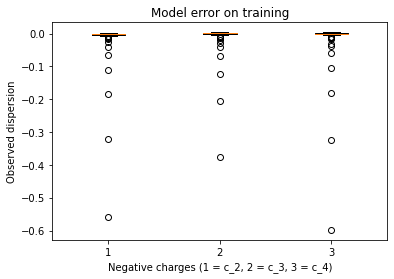

In [56]:
# Plot the error
plt.figure()
plt.boxplot(errorPerEpoch)
plt.xlabel("Negative charges (1 = c_2, 2 = c_3, 3 = c_4)")
plt.ylabel("Observed dispersion")
plt.title("Model error on training")
plt.show()

In [60]:
import random

# number of example predictions
nrExamplePredictions = 100

# Set model to eval mode
lstm.eval()

predictionError = np.empty((nrExamplePredictions, 3))
for examplePrediction in range(nrExamplePredictions):
    # Get a random index
    index = random.choice(range(len(simulation_test)))
    
    # Get corresponding tensors
    particlePositions = torch.tensor(simulation_test[index]).type(torch.FloatTensor).to(dev)
    particleCharges = torch.tensor(charges_test[index]).type(torch.FloatTensor).to(dev)
    
    # Forward propagate the particle positions through the model
    with torch.no_grad():
        predictedCharges = lstm(particlePositions)
        
        # Store prediction result in error
        prediction = predictedCharges[0].cpu().numpy()
        expected = particleCharges.cpu().numpy()
        predictionError[examplePrediction] = expected - prediction
    
    # Print results
    print(f'Predicted charges: {prediction}, Actual charges: {expected}')

Predicted charges: [-0.53045017 -0.45372543 -0.581346  ], Actual charges: [-0.70485425 -0.66174406 -0.45352829]
Predicted charges: [-0.30917373 -0.6047821  -0.30067468], Actual charges: [-0.20928842 -0.60037655 -0.04810857]
Predicted charges: [-0.41392642 -0.5519421  -0.4889437 ], Actual charges: [-0.30983463 -0.89006585 -0.01796825]
Predicted charges: [-0.5114611  -0.48019767 -0.591058  ], Actual charges: [-0.8288317  -0.25308523 -0.43637314]
Predicted charges: [-0.5047661  -0.49541333 -0.6148417 ], Actual charges: [-0.16873121 -0.1138682  -0.8036771 ]
Predicted charges: [-0.5504794  -0.39722735 -0.48049384], Actual charges: [-0.6185554  -0.5891298  -0.42420405]
Predicted charges: [-0.4891028  -0.5163381  -0.60805166], Actual charges: [-0.41475084 -0.22706938 -0.5925099 ]
Predicted charges: [-0.4624562  -0.53690684 -0.56578803], Actual charges: [-0.16006294 -0.9131096  -0.5270913 ]
Predicted charges: [-0.4840592  -0.50628424 -0.58247674], Actual charges: [-0.5206636  -0.62429523 -0.15

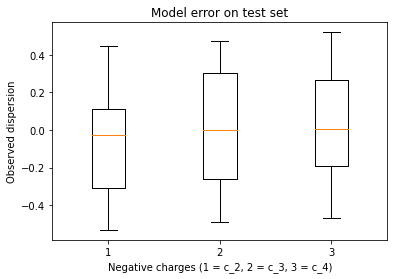

In [58]:
# Plot model error on test set
plt.figure()
plt.boxplot(predictionError)
plt.xlabel("Negative charges (1 = c_2, 2 = c_3, 3 = c_4)")
plt.ylabel("Observed dispersion")
plt.title("Model error on test set")
plt.show()

# Task 3.2

## Data Handling and Preprocessing

In [ ]:
#todo
# Let's add the static input at every call of the model, or design it in a way that has a seperate method for the static data (per simulation) for 3.2

In [ ]:

simulation_train_task32 = []
simulation_continued_train

simulation_train_task32_no_nothing = []
simulation_train_task32
for i in range(150):
    tensor = torch.Tensor(simulation_train_task32[i])
    simulation_test_no_nothing.append(tensor)

## Model Implementation

In [ ]:
#todo

## Model Training

In [ ]:
#todo

## Evaluation

In [ ]:
#todo